# Using A3TGCN for speed prediction of the traffic

The details about the data is shown in the notebook
https://github.com/mhmdrdwn/traffic/blob/main/notebooks/tgcn-seoul-dataset.ipynb

In [1]:
import warnings
from IPython.display import clear_output
warnings.filterwarnings('ignore')

In [2]:
import torch
pt_version = torch.__version__

!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-geometric
!pip install torch-geometric-temporal
clear_output()

In [3]:
import numpy as np
import pandas as pd

def read_data(features_csv, adj_csv):
    urban_core_speeds = pd.read_csv(features_csv, header=None)
    adj_matrix_df = pd.read_csv(adj_csv, header=None)
    adj_matrix = np.array(adj_matrix_df)

    speeds_df = urban_core_speeds.iloc[:, 7:]
    speeds = np.array(speeds_df)
    
    return adj_matrix_df, urban_core_speeds, adj_matrix, speeds

adj_matrix_df, urban_core_speeds, adj_matrix, speeds = read_data(
    '../input/seoul-speed-data/urban-core.csv', 
    '../input/seoul-speed-data/Adj(urban-core).csv')

In [4]:
"""Train test split the data"""
train_test_split = 0.75

split = int(speeds.shape[1] * train_test_split)
train_data = speeds[:, :split]
test_data = speeds[:, split:]

print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (304, 6480)
Test data:  (304, 2160)


In [5]:
"""Min max standardizing the data"""
max_speed = train_data.max()
min_speed = train_data.min()

train_data = (train_data - min_speed) / (max_speed - min_speed)
test_data = (test_data - min_speed) / (max_speed - min_speed)

train_data.shape, test_data.shape

((304, 6480), (304, 2160))

In [8]:
"""Ref: https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html"""

sequence_len = 10
prediction_len = 1

def build_features_labels(sequence_len, prediction_len, train_data, test_data):
    X_train, Y_train, X_test, Y_test = [], [], [], []

    for i in range(train_data.shape[1] - int(sequence_len + prediction_len - 1)):
        a = train_data[:, i : i + sequence_len + prediction_len]
        X_train.append(a[:, :sequence_len])
        Y_train.append(a[:, sequence_len:sequence_len+prediction_len])

    for i in range(test_data.shape[1] - int(sequence_len + prediction_len - 1)):
        b = test_data[:, i : i + sequence_len + prediction_len]
        X_test.append(b[:, :sequence_len])
        Y_test.append(b[:, sequence_len:sequence_len+prediction_len])

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = build_features_labels(sequence_len, prediction_len, train_data, test_data)

X_train_shape = X_train.shape
X_test_shape = X_test.shape

X_train = X_train.reshape(X_train_shape[0], X_train_shape[1], 1, X_train_shape[2])
X_test = X_test.reshape(X_test_shape[0], X_test_shape[1], 1, X_test_shape[2])

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(6470, 304, 1, 10)
(6470, 304, 1)
(2150, 304, 1, 10)
(2150, 304, 1)


We need to convert the input data into graph temporal object to feed to the model in the torch geometric library, The object we use here is Static Graph Temporal Signal. There are other object that are Dynamic. In Dynamic, we expect that the graph changes over time but here the graph topology does not change over time. We take the adjacency matrix and get the indices where there are connections between nodes and call it edge index. Edge attribute is the value of the connection between nodes. Those two are passed along with the traditional X and y (X is 10 steps in time series whie y is the step 12 in the series).

In [9]:
edges = np.nonzero(adj_matrix)
edges = np.vstack([edges, adj_matrix[edges]])
edge_index = edges[:2, :].astype(float)
edge_attr = edges[2, :].astype(float)
edge_index.shape, edge_attr.shape

((2, 1696), (1696,))

In [10]:
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
train_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_train, Y_train)
test_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_test, Y_test)

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=1, periods=1)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(1, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(1, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(1, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [26]:
# GPU support
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Create model and optimizers
model = TemporalGNN(node_features=1, periods=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(50): 
    loss = 0
    step = 0
    for snapshot in train_loader:
        snapshot = snapshot.to(device)
        y_hat = model(snapshot.x, snapshot.edge_index)
        loss = loss + torch.mean(torch.abs(y_hat-snapshot.y)) 
        step += 1
    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MAE: {:.4f}".format(epoch+1, loss.item()))

Epoch 1 train MAE: 0.1929
Epoch 2 train MAE: 0.1477
Epoch 3 train MAE: 0.1058
Epoch 4 train MAE: 0.0780
Epoch 5 train MAE: 0.0841
Epoch 6 train MAE: 0.1002
Epoch 7 train MAE: 0.0996
Epoch 8 train MAE: 0.0893
Epoch 9 train MAE: 0.0791
Epoch 10 train MAE: 0.0750
Epoch 11 train MAE: 0.0772
Epoch 12 train MAE: 0.0814
Epoch 13 train MAE: 0.0842
Epoch 14 train MAE: 0.0843
Epoch 15 train MAE: 0.0821
Epoch 16 train MAE: 0.0786
Epoch 17 train MAE: 0.0753
Epoch 18 train MAE: 0.0736
Epoch 19 train MAE: 0.0740
Epoch 20 train MAE: 0.0756
Epoch 21 train MAE: 0.0768
Epoch 22 train MAE: 0.0765
Epoch 23 train MAE: 0.0748
Epoch 24 train MAE: 0.0726
Epoch 25 train MAE: 0.0710
Epoch 26 train MAE: 0.0706
Epoch 27 train MAE: 0.0711
Epoch 28 train MAE: 0.0716
Epoch 29 train MAE: 0.0713
Epoch 30 train MAE: 0.0701
Epoch 31 train MAE: 0.0685
Epoch 32 train MAE: 0.0672
Epoch 33 train MAE: 0.0668
Epoch 34 train MAE: 0.0669
Epoch 35 train MAE: 0.0667
Epoch 36 train MAE: 0.0657
Epoch 37 train MAE: 0.0643
Epoch 38 t

KeyboardInterrupt: 

In [44]:
model.eval()
y_preds = list()
y_true = list()

for snapshot in test_loader:

    y = snapshot.y.cpu().numpy().reshape(-1)
    y_pred = model(snapshot.x, snapshot.edge_index).view(len(snapshot.x), -1).cpu().detach().numpy().reshape(-1)

    y = np.array(y * max_speed)
    y_pred = np.array((y_pred) * max_speed)
    y_preds.extend(list(y_pred))
    y_true.extend(list(y))
    
y_preds = np.array(y_preds)
y_true = np.array(y_true)
y_preds = y_preds.reshape(int(y_preds.shape[0]/304), 304)
y_true = y_true.reshape(int(y_true.shape[0]/304), 304)

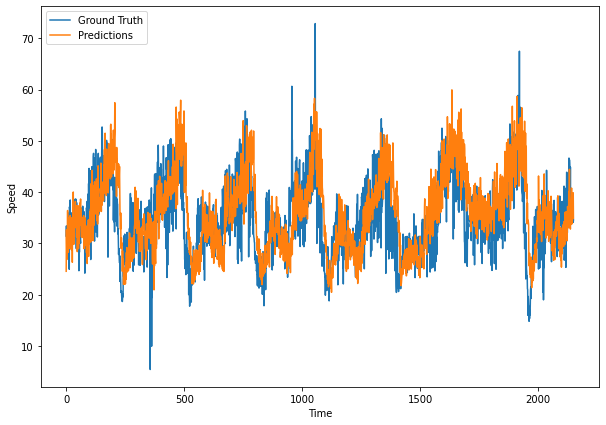

In [46]:
y_sample = y_true[:, 2]
y_pred_sample = y_preds[:, 2]


"""show the first label series"""
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(range(len(y_sample)), y_sample, label='Ground Truth')
plt.plot(range(len(y_pred_sample)), y_pred_sample, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend(loc="upper left")
plt.show()

In [47]:
"""Overall evaluatuation the predictions of the test data"""
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true +=  0.001 #add small values to true velocities to avoid division by zeros
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('RMSE: ', np.sqrt(mean_squared_error(y_true, y_preds)))
print('MAE: ', np.sqrt(mean_absolute_error(y_true, y_preds)))
print('MAPE: ', np.sqrt(mean_absolute_percentage_error(y_true, y_preds)))

RMSE:  7.918084
MAE:  2.4496741
MAPE:  5.27820032990873
